# Sentiment Analysis using BERT

BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.

### Import Libraries and Set the intial variables

In [1]:
!pip install transformers

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Load the data

In [4]:
df = pd.read_csv('./mixedexport.csv')
df.shape

(7199, 15)

In [5]:
# Let's have a look at the data 
df.head()

,id,link,author_id,created_at,text,sentiment,contains_mentions,referenced_replied_to,referenced_retweeted,referenced_quoted,likes,replies,retweets,quotes,bio
0,1.575629e+18,https://twitter.com/twitter/status/15756287833...,2.695222e+09,2022-09-29T23:29:10.000Z,u wanna butt in line for the bathroom bc ur ki...,negative,0,0,0,0,0,0,0,0,Jesus Christ is King
1,1.575628e+18,https://twitter.com/twitter/status/15756282504...,1.567603e+18,2022-09-29T23:27:03.000Z,@AriankaMarande2 She’s like this homophobic ma...,negative,1,1,0,0,0,1,0,0,🇺🇲🇳🇮 I watch alot of MMA/BOXING and Anime I 🙌💎
2,1.575628e+18,https://twitter.com/twitter/status/15756275297...,1.052126e+18,2022-09-29T23:24:11.000Z,If Andrew Tate catches me working a 9-5 but I'...,negative,0,0,0,0,1,0,0,0,🐐🐏🐐
3,1.575627e+18,https://twitter.com/twitter/status/15756271698...,4.136330e+07,2022-09-29T23:22:45.000Z,most of these dudes who quote andrew tate don’...,positive,0,0,0,0,0,1,0,0,dreamers dive in headfirst
4,1.575627e+18,https://twitter.com/twitter/status/15756268902...,1.487694e+18,2022-09-29T23:21:39.000Z,Soldier boy and Andrew tate wud make great fri...,negative,0,0,0,0,0,0,0,0,I’m an ass man 🍑


We can see that the most relevant column for us is content and replyContent and the score as well.

In [21]:
# Let's check for missing values 
df = df.dropna(subset=['sentiment'])

df.isnull().sum()



id                         0
link                       0
author_id                  0
created_at                 0
text                       0
sentiment                  0
contains_mentions          0
referenced_replied_to      0
referenced_retweeted       0
referenced_quoted          0
likes                      0
replies                    0
retweets                   0
quotes                     0
bio                      812
dtype: int64

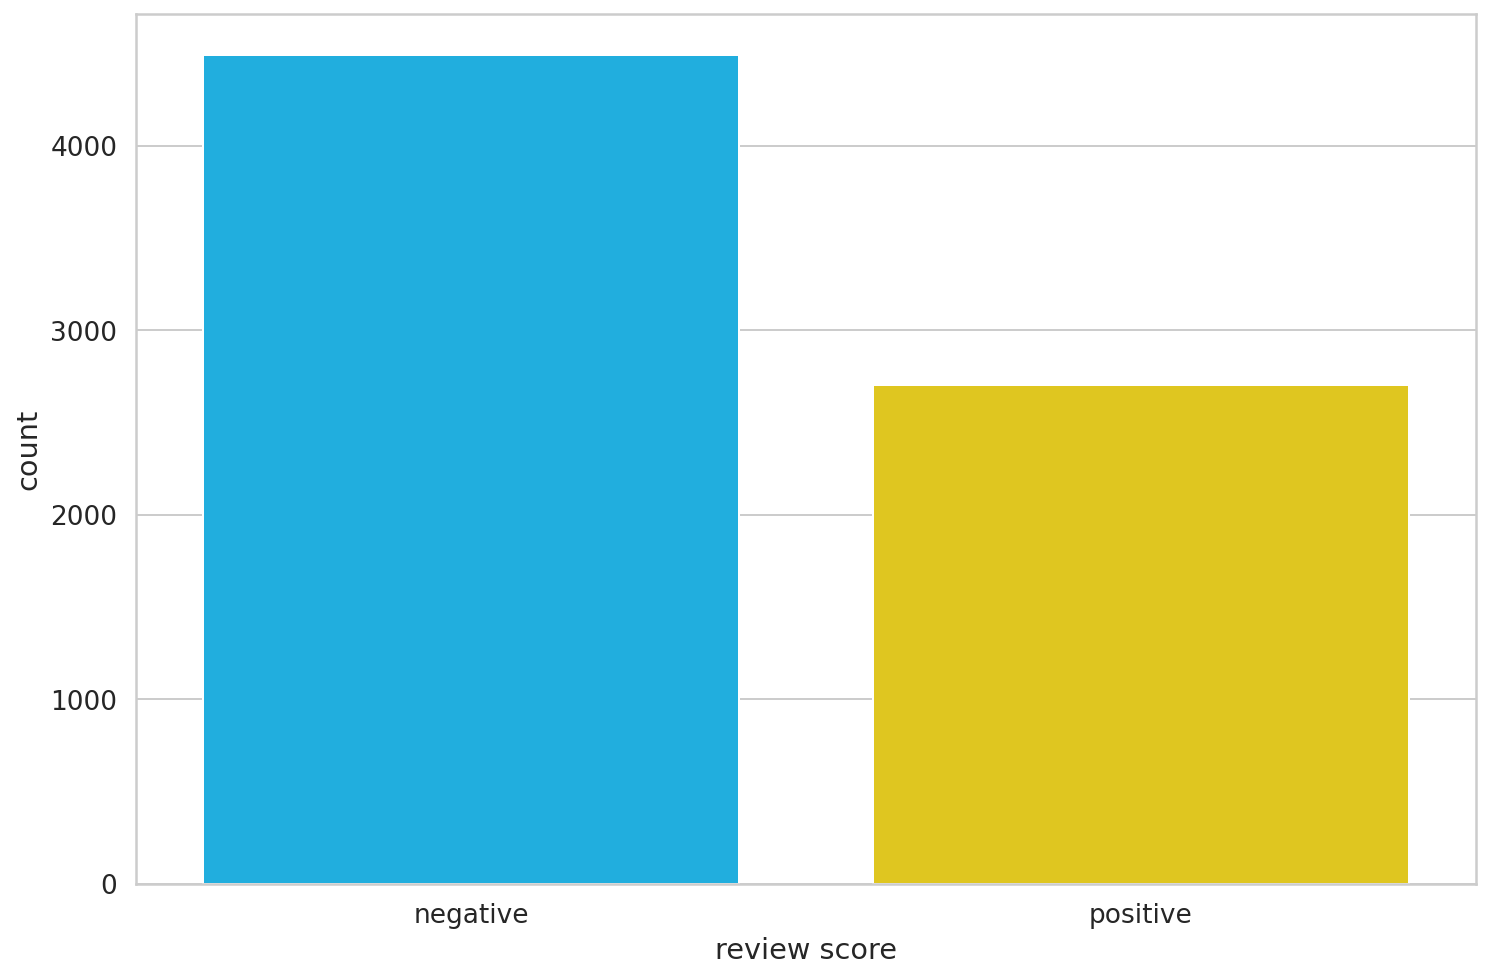

In [22]:
# Let's have a look at the class balance.
sns.countplot(df.sentiment)
plt.xlabel('review score');

In [38]:
df['sentiment']

0       0
1       0
2       0
3       1
4       0
       ..
7194    0
7195    1
7196    0
7197    1
7198    1
Name: sentiment, Length: 7192, dtype: int64

In [37]:
# Function to convert score to sentiment
def to_sentiment(rating):
    
#     rating = int(rating)
    
    # Convert to class
    if rating == 'negative':
        return 0
    elif rating == "positive":
        return 1

    else:
        print(rating)

# Apply to the dataset 
df['sentiment'] = df.sentiment.apply(to_sentiment)

In [24]:
# # Plot the distribution
# class_names = ['negative', 'neutral', 'positive']
# ax = sns.countplot(df.sentiment)
# plt.xlabel('review sentiment')
# ax.set_xticklabels(class_names)

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation. 

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word. 

In [39]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [40]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [41]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

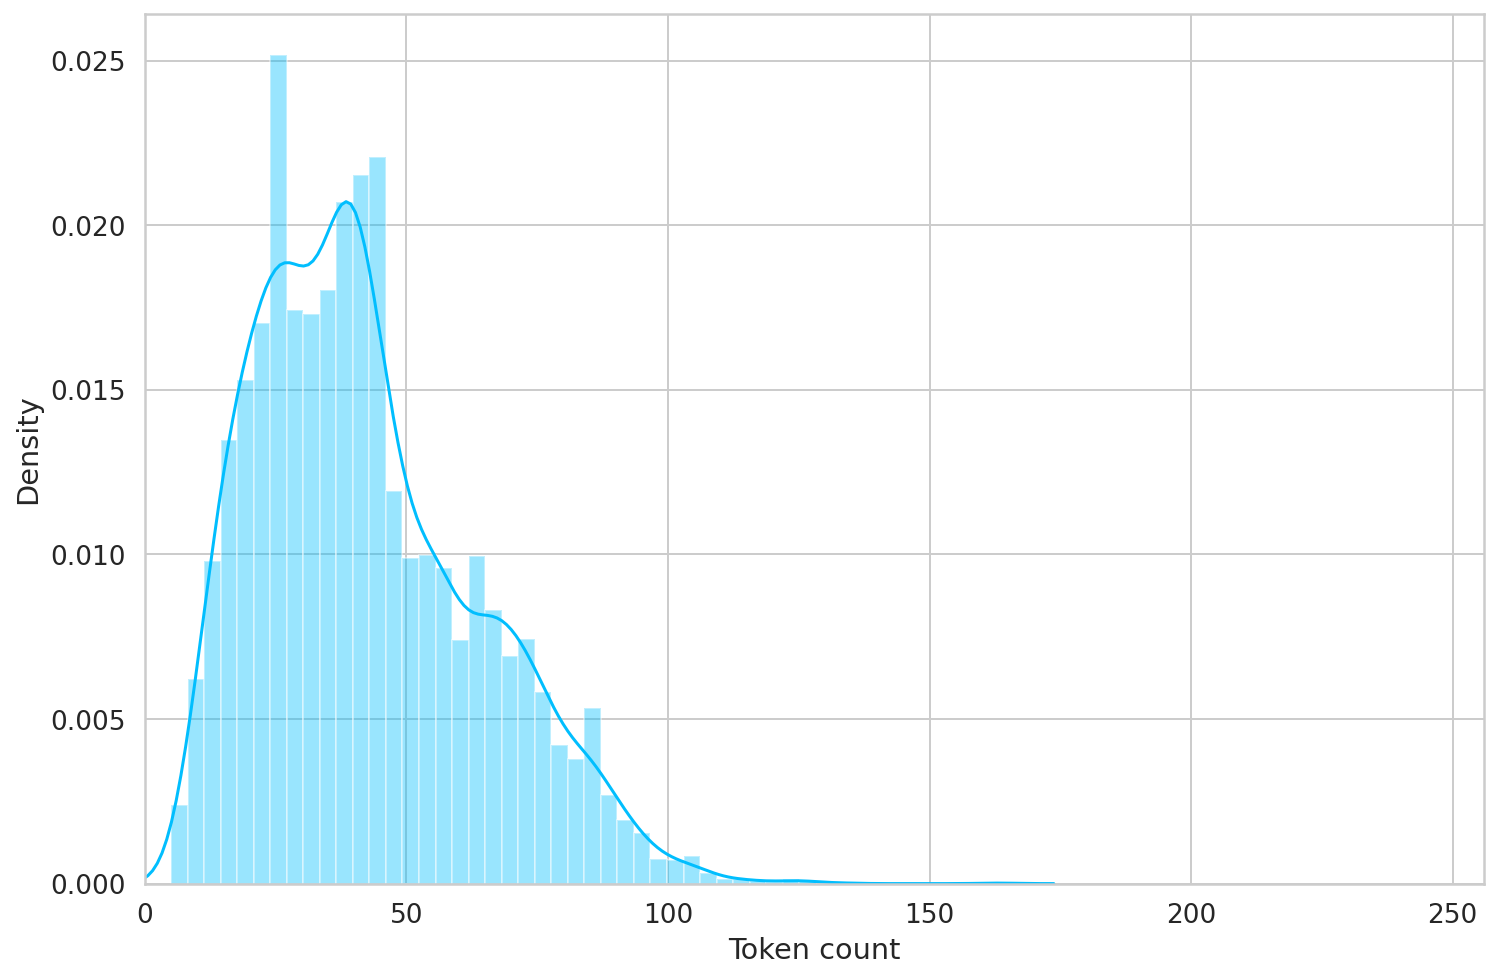

In [42]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160. 

In [43]:
MAX_LEN = 110

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily. 

In [44]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [45]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.1, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(5753, 15) (1295, 15) (144, 15)


Create a dataloader to release data in batches.

In [46]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [47]:
# Create train, test and val data loaders
BATCH_SIZE = 64
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [48]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([64, 110])
torch.Size([64, 110])
torch.Size([64])


## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [49]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [50]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
#         import pdb; pdb.set_trace()
        #  Add a dropout layer 
        output = self.drop(pooled_output['pooler_output'])
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [52]:
# Instantiate the model and move to classifier
class_names = ['negative', 'positive']

model = SentimentClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [53]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [54]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [55]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in tqdm(data_loader):

        
        
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [56]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [57]:
# !pip install tdqm
from tqdm import tqdm


In [60]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(EPOCHS)):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------



100%|██████████| 90/90 [00:37<00:00,  2.39it/s]


Train loss 0.5781744188732572 accuracy 0.6987658612897619



100%|██████████| 21/21 [00:03<00:00,  6.46it/s]


Val   loss 0.4668044831071581 accuracy 0.7791505791505792



 10%|█         | 1/10 [00:41<06:12, 41.44s/it]

Epoch 2/10
----------



100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Train loss 0.33145002557171716 accuracy 0.8588562489136103



100%|██████████| 21/21 [00:03<00:00,  6.25it/s]


Val   loss 0.5962832087562198 accuracy 0.7907335907335907



 20%|██        | 2/10 [01:24<05:37, 42.22s/it]

Epoch 3/10
----------



100%|██████████| 90/90 [00:40<00:00,  2.25it/s]


Train loss 0.1670933880739742 accuracy 0.9379454197809839



100%|██████████| 21/21 [00:03<00:00,  6.15it/s]


Val   loss 0.7242367693356105 accuracy 0.8123552123552124



 30%|███       | 3/10 [02:08<05:01, 43.03s/it]

Epoch 4/10
----------



100%|██████████| 90/90 [00:40<00:00,  2.22it/s]


Train loss 0.08293589561039375 accuracy 0.9742742916739093



 40%|████      | 4/10 [02:52<04:20, 43.43s/it]

Val   loss 0.8284542092255184 accuracy 0.8054054054054054

Epoch 5/10
----------



100%|██████████| 90/90 [00:40<00:00,  2.22it/s]


Train loss 0.04980922260890818 accuracy 0.9845298105336346



 50%|█████     | 5/10 [03:36<03:38, 43.63s/it]

Val   loss 0.8407829574176243 accuracy 0.8123552123552124

Epoch 6/10
----------



100%|██████████| 90/90 [00:40<00:00,  2.22it/s]


Train loss 0.027379715092764753 accuracy 0.9928732835042587



100%|██████████| 21/21 [00:03<00:00,  6.12it/s]


Val   loss 1.026238222916921 accuracy 0.8162162162162162



 60%|██████    | 6/10 [04:20<02:55, 43.92s/it]

Epoch 7/10
----------



100%|██████████| 90/90 [00:40<00:00,  2.21it/s]


Train loss 0.010433023625066401 accuracy 0.9972188423431254



 70%|███████   | 7/10 [05:04<02:11, 43.99s/it]

Val   loss 1.1488909380776542 accuracy 0.8138996138996138

Epoch 8/10
----------



100%|██████████| 90/90 [00:40<00:00,  2.20it/s]


Train loss 0.006404234240795227 accuracy 0.9977403094037894



 80%|████████  | 8/10 [05:49<01:28, 44.11s/it]

Val   loss 1.2835234942890348 accuracy 0.8084942084942085

Epoch 9/10
----------



100%|██████████| 90/90 [00:40<00:00,  2.20it/s]


Train loss 0.007248519952635333 accuracy 0.998435598818008



 90%|█████████ | 9/10 [06:33<00:44, 44.20s/it]

Val   loss 1.2654847900072734 accuracy 0.8123552123552124

Epoch 10/10
----------



100%|██████████| 90/90 [00:41<00:00,  2.19it/s]


Train loss 0.0033717242533586817 accuracy 0.9989570658786721



100%|██████████| 10/10 [07:18<00:00, 43.81s/it]

Val   loss 1.2612640403565907 accuracy 0.8131274131274131

CPU times: user 7min 13s, sys: 6.17 s, total: 7min 19s
Wall time: 7min 18s


In [61]:
device

device(type='cuda')

The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

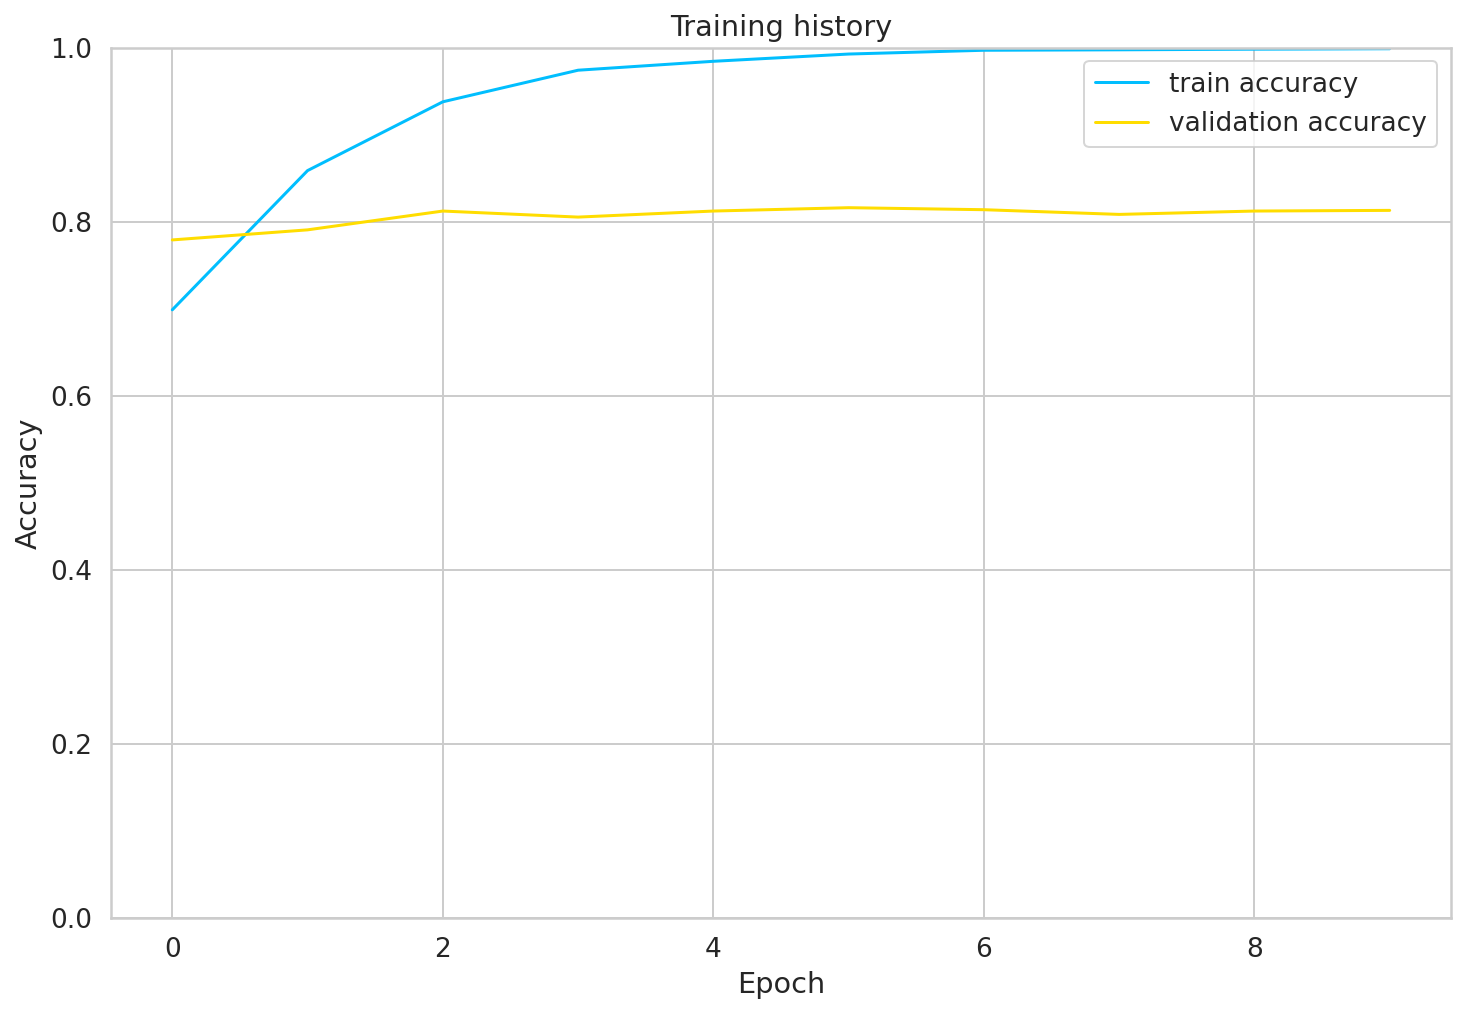

In [62]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

In [63]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

100%|██████████| 3/3 [00:00<00:00,  8.39it/s]


0.8333333333333333

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [64]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [65]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [66]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.86      0.88      0.87        91
    positive       0.78      0.75      0.77        53

    accuracy                           0.83       144
   macro avg       0.82      0.82      0.82       144
weighted avg       0.83      0.83      0.83       144



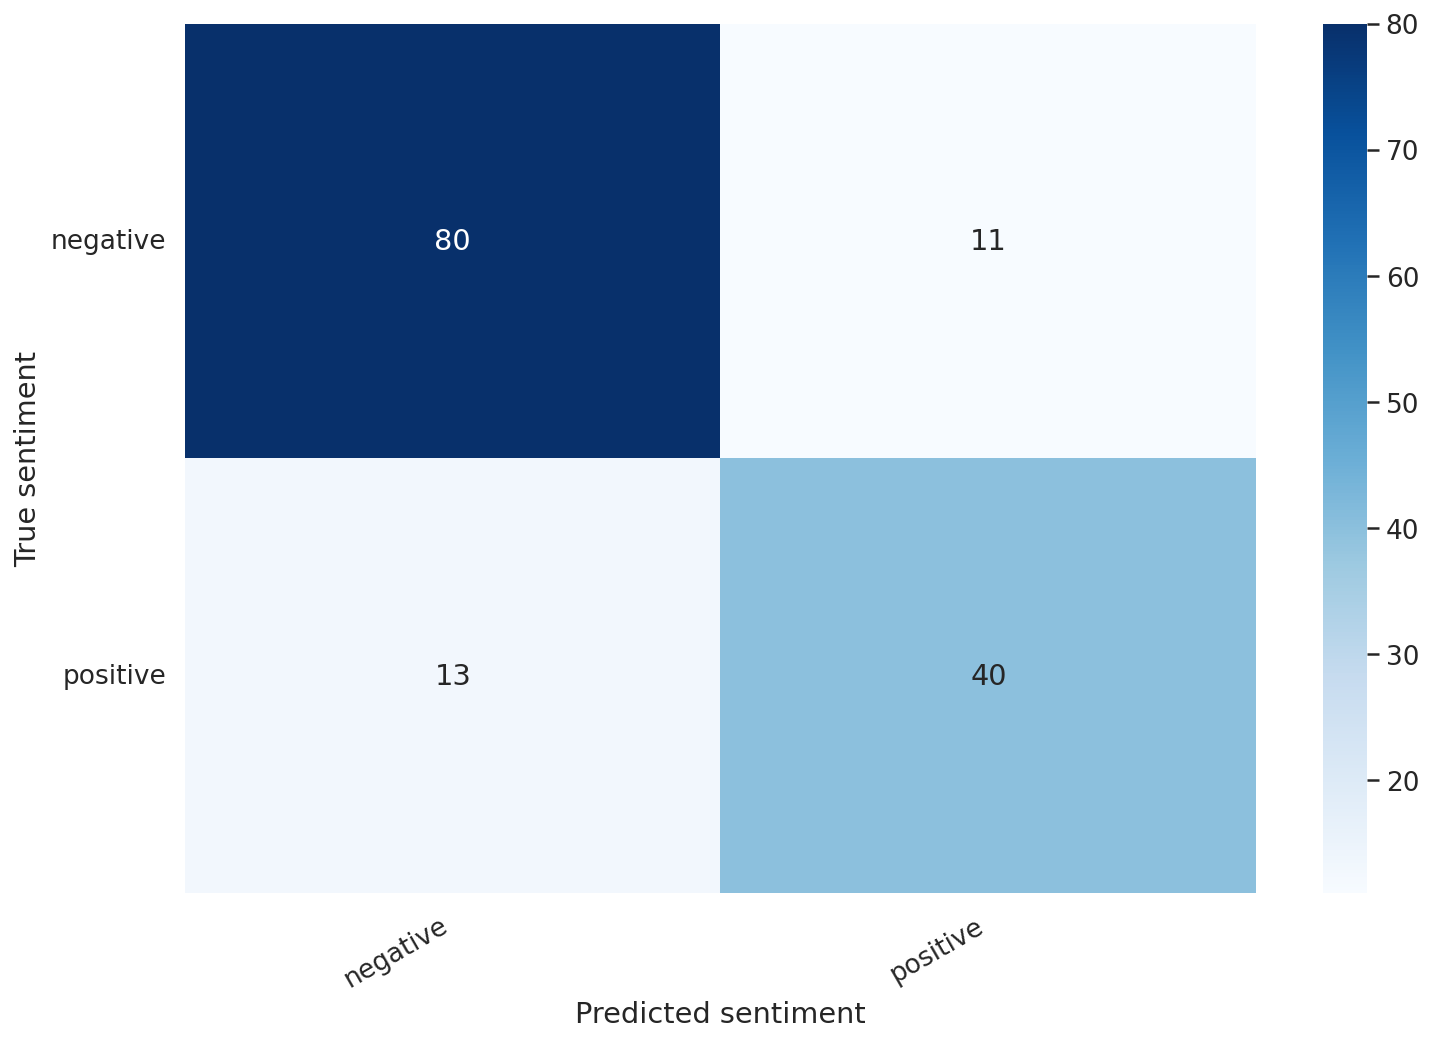

In [67]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [68]:
review_text = "I love completing my todos! Best app ever!!!"

In [69]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [70]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
